## MSDS 7333 Project 1 -- Predicting Location via Indoor Positioning Systems

#### Stephen Hayden, Joe Schueder, Nicole Witten, Kevin Mendonsa



### Introduction



In [43]:
import pandas as pd

url_dataset = 'https://raw.githubusercontent.com/jjschueder/7331DataMiningNotebooks/master/Live%20Assignments/df1hotmerge2.csv'
url_dataset1 = 'https://raw.githubusercontent.com/jjschueder/7333QTW/master/trainexport.csv'
url_dataset2 = 'https://raw.githubusercontent.com/jjschueder/7333QTW/master/onlineSummary.csv'
    
onlineSummary = pd.read_csv(url_dataset2)
offlineSummary = pd.read_csv(url_dataset1) 


In [44]:
offlineSummary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 11 columns):
Unnamed: 0           1162 non-null object
posXY                1162 non-null object
posX                 1162 non-null int64
posY                 1162 non-null int64
00:0f:a3:39:e1:c0    1162 non-null float64
00:14:bf:3b:c7:c6    1162 non-null float64
00:14:bf:b1:97:81    1162 non-null float64
00:14:bf:b1:97:8a    1162 non-null float64
00:14:bf:b1:97:8d    1162 non-null float64
00:14:bf:b1:97:90    1162 non-null float64
angle                1162 non-null int64
dtypes: float64(6), int64(3), object(2)
memory usage: 100.0+ KB


In [42]:
onlineSummary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 12 columns):
Unnamed: 0           60 non-null object
posXY                60 non-null object
posX                 60 non-null float64
posY                 60 non-null float64
orientation          60 non-null float64
angle                60 non-null int64
00:0f:a3:39:e1:c0    60 non-null float64
00:14:bf:3b:c7:c6    60 non-null float64
00:14:bf:b1:97:81    60 non-null float64
00:14:bf:b1:97:8a    60 non-null float64
00:14:bf:b1:97:8d    60 non-null float64
00:14:bf:b1:97:90    60 non-null float64
dtypes: float64(9), int64(1), object(2)
memory usage: 5.8+ KB


In [45]:
# Import all necessary libraries we will be using in our dataset

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
import statistics
import random

from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, RFE, SelectFromModel

from sklearn.preprocessing import StandardScaler, Binarizer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, auc, roc_curve
from IPython.display import display, HTML

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit, StratifiedShuffleSplit

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor,AdaBoostClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')



In [8]:
print(onlineSummary.shape)
onlineSummary.head()

(7968, 16)


,Unnamed: 0,time,posX,posY,orientation,mac,signal,rawTime,angle,posXY,medSignal,avgSignal,num,sdSignal,iqrSignal,dist
0,3,2006-02-11 01:31:58,0,0,0.0,00:0f:a3:39:e1:c0,-53,1139643118358,0,0-0,-51.0,-51.154545,110,1.408925,2.00,9.794897
1,24507,2006-02-11 02:03:44,0,1,0.7,00:0f:a3:39:e1:c0,-49,1139645024306,0,0-1,-51.0,-50.572727,110,2.198661,3.00,9.183681
2,221774,2006-02-11 05:46:02,0,10,0.9,00:0f:a3:39:e1:c0,-53,1139658362231,0,0-10,-56.0,-56.200000,110,1.123559,1.00,8.363014
3,229185,2006-02-11 05:54:05,0,11,0.4,00:0f:a3:39:e1:c0,-53,1139658845177,0,0-11,-53.0,-54.681818,110,3.421282,7.00,8.850989
4,236489,2006-02-11 06:02:32,0,12,0.2,00:0f:a3:39:e1:c0,-54,1139659352613,0,0-12,-55.0,-56.600000,110,3.561259,7.75,9.420191


## Modeling and Evaluation 1

Within this notebook, we have built models to evaluate classification problems.  This is a multi-classification problem in which our goal is to correctly classify  A detailed description of the metrics we will use to evaluate the models are noted below.

An ROC curve, also known as a Reciever Operation Characteristic Curve is a plot that calculates and can be used to compare the classifiers we will use in our modeling along with the true positive rate (TPR) and false positive rate (FPR) they convey. From a topline level, you can use the Area Under the Curve (AUC) to help detirmine which can better pair an observation with the correct liquor cateogry. An AUC score of 1.0 denotes a perfect classifier and an area of 0.5 represents a model is no better than a random guess.

In addition to the ROC-AUC value we will use to evaluate classifiers, we will be using other evaluators as well. 

**Accuracy** - Accuracy is the total number of correct predictions over the total number of predictions made. Accuracy will be plotted in our AUC curve and, while not perfect, is a good singlular measure to evaluate a model. Just be careful that we aren't overclassifying unbalalnced variables. 

Accuracy = (TP + TN)/(TP + FP + FN + TN)

**Precision** - Precision is the Proportions of true positives over the total number of positive outcomes whether accurately predicted or inaccurately predicted. Precision is useful to us because it will help us better understand which model is accurately picking correct classes and not resting on selecting incorrect classes. 

Precision = (TP) / (TP + FP)

**Recall** - Also known as sensitivity, recall is the proportion of positive outcomes that were correctly classified by our model. Essentially it tells us how many values we incorrectly predicted while the precision can tell us more about what we correctly classified. Recall is good as a pair with precision, as it will help us tell if our model is overfit or selecting a single class and not training itself. 

Recall/Sensitivity = (TP) / (TP + FN)

**F1 Score** - Another measure of accuracy that accounts for the true negatives and false positives. 

F1 score = 2(True Positive Rate * True Negatives)/(True Positives + True Negatives)

The aim of our modeling is to focus on maximizing our precision, recall, and accuracy scores in our models



In [46]:
#Source: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedMiddleSchoolCampuses.ipynb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)


def EvaluateClassifierEstimator(classifierEstimator, X, Y2, cv):



#Perform cross validation 
    scores = cross_validate(classifierEstimator, X, Y2,
                            scoring=['accuracy', 'precision','recall'], 
                            cv=cv, return_train_score=True, 
                            )

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Rreavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average Recall for all cv folds is: \t\t\t {Rreavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Rreavg=Rreavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    print(scoresResults)
    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, Y2, cv):
    
  #Perform cross validation 
  from sklearn.model_selection import cross_val_predict
  predictions = cross_val_predict(classifierEstimator, 
                                  X, Y2, cv=cv)
    
#model evaluation 
  from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#pass true test set values and predictions to classification_report
  classReport = classification_report(Y2,predictions)
  confMat = confusion_matrix(Y2,predictions)
  acc = accuracy_score(Y2,predictions)
    
  print(classReport)
  print(confMat)
  print(acc)
#from imblearn.over_sampling import SMOTE    
def EvaluateClassifierEstimator3(classifierEstimator, X, Y2, cv):
  from sklearn import metrics as mt
  for fold, (train_index, test_index) in enumerate(cv.split(X,Y2)):
     X_train = X[train_index]    
     y_train = Y2[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
     X_test = X[test_index]
     y_test = Y2[test_index]  # See comment on ravel and  y_train
     sm = SMOTE(random_state=101)
     X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
     classifierEstimator.fit(X_train, y_train) 
     y_pred = classifierEstimator.predict(X_test)
     acc = mt.accuracy_score(y_test,y_pred)
     conf = mt.confusion_matrix(y_test,y_pred)
     print("====Iteration",fold," ====")
     print("accuracy", acc )
     print("confusion matrix\n",conf)


## Modeling and Evaluation 2
Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.

In [47]:
#class percentage split
dfgrp = onlineSummary.groupby(['posXY', 'posX', 'posY'])
onlineSummary['posXY'].value_counts()
dfgrp['posXY'].count() / len(onlineSummary) *100

posXY       posX   posY 
0-0.05      0.00   0.05     1.666667
0.15-9.42   0.15   9.42     1.666667
0.31-11.09  0.31   11.09    1.666667
0.47-8.2    0.47   8.20     1.666667
0.78-10.94  0.78   10.94    1.666667
0.93-11.69  0.93   11.69    1.666667
1.08-12.19  1.08   12.19    1.666667
1.24-3.93   1.24   3.93     1.666667
1.39-6.61   1.39   6.61     1.666667
1.52-9.32   1.52   9.32     1.666667
1.55-0.96   1.55   0.96     1.666667
1.58-5.26   1.58   5.26     1.666667
1.71-1.81   1.71   1.81     1.666667
1.86-8.08   1.86   8.08     1.666667
10.23-6.88  10.23  6.88     1.666667
10.46-5.8   10.46  5.80     1.666667
10.62-3.87  10.62  3.87     1.666667
10.99-7.19  10.99  7.19     1.666667
11.39-5     11.39  5.00     1.666667
11.76-7.76  11.76  7.76     1.666667
12.16-5.25  12.16  5.25     1.666667
12.18-3.4   12.18  3.40     1.666667
12.26-6.72  12.26  6.72     1.666667
12.55-7.38  12.55  7.38     1.666667
12.95-5.25  12.95  5.25     1.666667
14.98-7.55  14.98  7.55     1.666667
16.44-7.45  1

In [48]:
onlineSummary['posXY'].value_counts()

1.08-12.19    1
28.12-7.57    1
0.15-9.42     1
10.23-6.88    1
12.26-6.72    1
21.23-5.47    1
12.95-5.25    1
21.6-7.63     1
12.55-7.38    1
7.48-7.36     1
1.86-8.08     1
0.93-11.69    1
10.62-3.87    1
1.24-3.93     1
9.86-3.88     1
11.76-7.76    1
8.56-7.64     1
22.76-5.06    1
32.54-7.08    1
3.44-7.43     1
21.98-7.46    1
23.36-3.4     1
22.38-3.94    1
10.46-5.8     1
0.47-8.2      1
16.44-7.45    1
1.39-6.61     1
22.3-6.36     1
1.71-1.81     1
14.98-7.55    1
21.45-6.62    1
23.24-7.5     1
2.49-7.6      1
32.16-7.08    1
0.31-11.09    1
29.58-7.93    1
23.53-4.22    1
25.76-7.34    1
21.3-3.8      1
23.9-7        1
24.31-3.89    1
6-7.88        1
26.71-7.5     1
25.23-7.78    1
4.51-7.63     1
0.78-10.94    1
9.46-7.77     1
24.7-7.7      1
1.52-9.32     1
12.16-5.25    1
0-0.05        1
2.02-7.45     1
31.06-7.19    1
9.08-7.24     1
11.39-5       1
1.58-5.26     1
12.18-3.4     1
31.78-7.62    1
1.55-0.96     1
10.99-7.19    1
Name: posXY, dtype: int64

In [49]:
offlineSummary['posXY'].value_counts()

8-3     7
2-9     7
0-1     7
2-12    7
15-3    7
       ..
11-3    7
1-12    7
12-6    7
7-3     7
21-5    7
Name: posXY, Length: 166, dtype: int64

In [50]:
onlineSummary.columns

Index(['Unnamed: 0', 'posXY', 'posX', 'posY', 'orientation', 'angle',
       '00:0f:a3:39:e1:c0', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:81',
       '00:14:bf:b1:97:8a', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90'],
      dtype='object')

In [51]:
offlineSummary.columns

Index(['Unnamed: 0', 'posXY', 'posX', 'posY', '00:0f:a3:39:e1:c0',
       '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:81', '00:14:bf:b1:97:8a',
       '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90', 'angle'],
      dtype='object')

In [52]:
onlineSummary.head()

,Unnamed: 0,posXY,posX,posY,orientation,angle,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0,0-0.05,0-0.05,0.00,0.05,130.5,135,-52.227273,-62.948980,-61.813953,-40.068966,-63.043011,-55.233333
1,0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-55.275229,-73.961905,-72.701031,-47.813084,-69.454545,-46.880000
2,0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-51.709091,-70.082474,-70.098901,-54.088235,-69.131579,-53.886598
3,0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-49.500000,-64.258065,-72.597701,-45.652893,-60.797468,-49.580000
4,0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-53.263636,-66.960000,-66.809524,-48.413793,-65.000000,-54.846939


In [53]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt

cv = StratifiedKFold(n_splits=10)

features = ['angle',
       '00:0f:a3:39:e1:c0', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:81',
       '00:14:bf:b1:97:8a', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:90']

X2 = offlineSummary[features].copy()
X3 = onlineSummary[features].copy()
scaler = StandardScaler()
scaler.fit(X2)

#This makes our model's coefficients take on the same scale for accurate feature importance analysis
#Notice we scaled the data before the cross validation
X = scaler.transform(X2)
X = offlineSummary[features].copy()
Y= offlineSummary[['posXY']].copy()
Y3= onlineSummary[['posXY']].copy()
Y2 = Y.values

#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=2, test_size=0.20, random_state=0)

CPU times: user 7.45 ms, sys: 0 ns, total: 7.45 ms
Wall time: 9.65 ms


In [54]:
from sklearn import metrics as mt

# train and test split before resampling
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, test_size = 0.01, random_state = 101) 


## Classification 


### Task 1 - Modeling and Evaluation 3
Create different classification models for each task e.g., random forest, KNN. 

The algorithms used are as follows:  

*   K-Nearest Neighbor
*   Random Forest Classification


#### Model 1: KNN Classification

In [236]:

param_grid = [
    {
         'weights': ['uniform','distance'],
         'leaf_size': [5,10, 20],
         'metric': ['minkowski','euclidean', 'manhattan'],
         'n_neighbors':[2,3,5, 6,7],
         
    }
]

clf_KNN = KNeighborsClassifier()
grid_search_KNN = GridSearchCV(clf_KNN, param_grid=param_grid,cv=cv,n_jobs=-1, verbose=1, scoring='accuracy' )

KNearest_model1 = grid_search_KNN.fit(X, Y)

y_KNN_score1 = KNearest_model1.predict(X1_test)



Fitting 2 folds for each of 90 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.8s finished


Our first modeling procedure we ran was a KNN classification. Detail on the concept behind it can be found below, but on this particular version, we are using our smote engineered features to fit the model and running a grid search procedure to select the best hyperparameter. 

In [237]:
classifierEstimaterKNN1 = KNearest_model1.best_estimator_
classifierEstimaterKNN1


KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

According to our grid search, the best estimator is to include 5 neighbors, a leaf size of 10 and a minkowski metric to learn from. 

In [57]:
#import pickle
#filename = r'C:/Users/jjsch/Documents/GitHub/7331lab1/7331DataMiningNotebooks/lab2/classifierEstimaterKNN1.pickle'
#infile = open(filename,'rb')
#classifierEstimaterKNN1 = pickle.loads(infile)
#infile.close()
#outfile = open(filename,'wb')
#pickle.dumps(classifierEstimaterKNN1, filename)
#from joblib import dump, load
#dump(classifierEstimaterKNN1, filename)

In [238]:
y_KNN_score1 = classifierEstimaterKNN1.predict(X3)
y_KNN_score1

array(['1-2', '1-12', '1-10', '1-0', '0-9', '2-11', '1-10', '0-3', '1-6',
       '2-10', '0-4', '1-4', '1-1', '1-8', '7-7', '10-6', '11-3', '12-5',
       '11-4', '7-8', '13-5', '13-3', '12-7', '10-6', '12-4', '17-8',
       '17-7', '0-7', '2-1', '23-4', '20-3', '21-8', '22-5', '23-7',
       '22-6', '23-7', '24-4', '16-3', '22-3', '24-3', '16-3', '21-3',
       '21-6', '27-8', '26-7', '27-8', '25-8', '31-7', '5-7', '30-7',
       '29-7', '31-7', '27-7', '3-3', '6-8', '6-8', '10-4', '9-7', '10-7',
       '11-3'], dtype=object)

In [239]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("Precision Score is: {}" .format(precision_score(Y3, y_KNN_score1, average='weighted')))
print("Recall Score is: {}" .format(recall_score(Y3, y_KNN_score1, average='weighted')))
print("F1 Score is: {}" .format(f1_score(Y3, y_KNN_score1, average='weighted')))

Precision Score is: 0.0
Recall Score is: 0.0
F1 Score is: 0.0


In [240]:
Y3.head()

,posXY
0,0-0.05
1,0.15-9.42
2,0.31-11.09
3,0.47-8.2
4,0.78-10.94


In [241]:
y1_test = Y3['posXY'].str.split("-", n = 1, expand = True)

In [242]:
yscore = pd.DataFrame(y_KNN_score1)

In [243]:
yscore=yscore[0].str.split("-", n = 1, expand = True)

In [245]:
yscore.head()

,0,1
0,1,2
1,1,12
2,1,10
3,1,0
4,0,9


In [246]:
y1_test[0] = y1_test[0].astype(float) 
y1_test[0] = y1_test[0].round()
y1_test[1] = y1_test[1].astype(float) 
y1_test[1] = y1_test[1].round()
y1_test.head()

,0,1
0,0.0,0.0
1,0.0,9.0
2,0.0,11.0
3,0.0,8.0
4,1.0,11.0


In [247]:
y1_test = y1_test.reset_index()
y1_test.index

RangeIndex(start=0, stop=60, step=1)

In [248]:
yscore.head()

,0,1
0,1,2
1,1,12
2,1,10
3,1,0
4,0,9


In [249]:
ygroup2 = y1_test.reset_index()
ygroup2 = pd.merge(ygroup2, yscore, left_index=True, right_index=True)
ygroup2.head()


,level_0,index,0_x,1_x,0_y,1_y
0,0,0,0.0,0.0,1,2
1,1,1,0.0,9.0,1,12
2,2,2,0.0,11.0,1,10
3,3,3,0.0,8.0,1,0
4,4,4,1.0,11.0,0,9


In [250]:

ygroup2['0_x'] = ygroup2['0_x'].astype(float) 
ygroup2['1_x'] = ygroup2['1_x'].astype(float) 
ygroup2['0_y'] = ygroup2['0_y'].astype(float) 
ygroup2['1_y'] = ygroup2['1_y'].astype(float) 
ygroup2['xdist'] = ygroup2['0_x'] - ygroup2['0_y']
ygroup2['ydist'] = ygroup2['1_x'] - ygroup2['1_y']
ygroup2['obatuple'] = ygroup2[['0_x', '1_x']].apply(tuple, axis=1)
ygroup2['obttuple'] = ygroup2[['0_y', '1_y']].apply(tuple, axis=1) 

In [251]:
ygroup2['xsqr'] = (ygroup2['0_x'] - ygroup2['0_y'])**2
ygroup2['ysqr'] = (ygroup2['1_x'] - ygroup2['1_y'])**2

In [252]:
ygroup2['distance'] = ygroup2['xsqr'] + ygroup2['ysqr']

In [253]:
ygroup2['distancefinalerror'] = np.sqrt(ygroup2['distance'])

In [254]:
ygroup2.head()

,level_0,index,0_x,1_x,0_y,1_y,xdist,ydist,obatuple,obttuple,xsqr,ysqr,distance,distancefinalerror
0,0,0,0.0,0.0,1.0,2.0,-1.0,-2.0,"(0.0, 0.0)","(1.0, 2.0)",1.0,4.0,5.0,2.236068
1,1,1,0.0,9.0,1.0,12.0,-1.0,-3.0,"(0.0, 9.0)","(1.0, 12.0)",1.0,9.0,10.0,3.162278
2,2,2,0.0,11.0,1.0,10.0,-1.0,1.0,"(0.0, 11.0)","(1.0, 10.0)",1.0,1.0,2.0,1.414214
3,3,3,0.0,8.0,1.0,0.0,-1.0,8.0,"(0.0, 8.0)","(1.0, 0.0)",1.0,64.0,65.0,8.062258
4,4,4,1.0,11.0,0.0,9.0,1.0,2.0,"(1.0, 11.0)","(0.0, 9.0)",1.0,4.0,5.0,2.236068


In [255]:
ygroup2['distancefinalerror'].mean()

2.2653505924645714

In [256]:
ygroup2['distancefinalerror'].sum()

135.92103554787428

In [257]:
x1, x2, y1, y2 = None,None,None,None

In [258]:
ygroup2.tail()

,level_0,index,0_x,1_x,0_y,1_y,xdist,ydist,obatuple,obttuple,xsqr,ysqr,distance,distancefinalerror
55,55,55,7.0,7.0,6.0,8.0,1.0,-1.0,"(7.0, 7.0)","(6.0, 8.0)",1.0,1.0,2.0,1.414214
56,56,56,9.0,8.0,10.0,4.0,-1.0,4.0,"(9.0, 8.0)","(10.0, 4.0)",1.0,16.0,17.0,4.123106
57,57,57,9.0,7.0,9.0,7.0,0.0,0.0,"(9.0, 7.0)","(9.0, 7.0)",0.0,0.0,0.0,0.000000
58,58,58,9.0,8.0,10.0,7.0,-1.0,1.0,"(9.0, 8.0)","(10.0, 7.0)",1.0,1.0,2.0,1.414214
59,59,59,10.0,4.0,11.0,3.0,-1.0,1.0,"(10.0, 4.0)","(11.0, 3.0)",1.0,1.0,2.0,1.414214


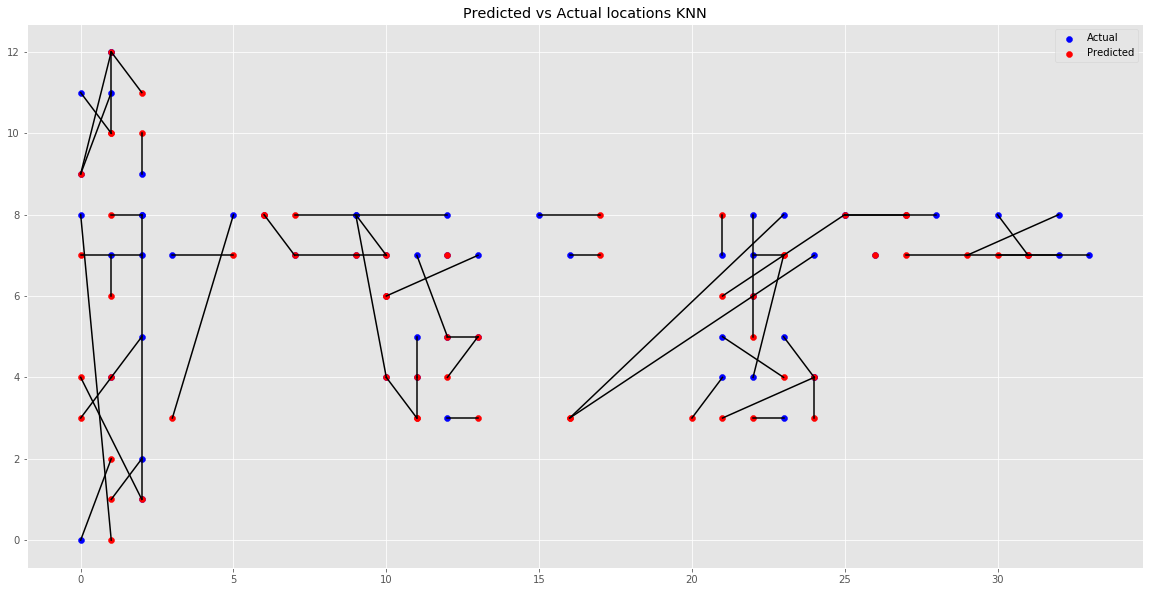

In [282]:
plt.figure(figsize=(20,10))
plt.title('Predicted vs Actual locations KNN')
for i, row in ygroup2.iterrows():
    x1, x2 = ygroup2.loc[i,'0_x'], ygroup2.loc[i,'0_y']
    y1, y2 = ygroup2.loc[i,'1_x'], ygroup2.loc[i,'1_y']
    plt.plot([x1,x2], [y1,y2],'k-')
#plt.scatter(ygroup2['0_x'], ygroup2['1_x'], c = 'blue', label = 'Actual')
#plt.scatter(ygroup2['0_y'], ygroup2['1_y'], c = 'red', label = 'Predicted')
p1 = plt.scatter(ygroup2['0_x'], ygroup2['1_x'], c = 'blue', label = 'Actual')
p2 = plt.scatter(ygroup2['0_y'], ygroup2['1_y'], c = 'red', label = 'Predicted')
plt.legend((p1, p2), ('Actual', 'Predicted'))



#### Model 2: Random Forest Classification

In [262]:
param_grid = [
    {
         'n_estimators': [200, 500], 
         'max_depth': [20,30,35],
         'random_state':[101]
     }
]

clf_RF = RandomForestClassifier()
grid_search_RF = GridSearchCV(clf_RF, param_grid=param_grid, cv=cv,n_jobs=-1, verbose=1, scoring='accuracy' )

RandomForest_model1 = grid_search_RF.fit(X, Y)

y_RF_score1 = RandomForest_model1.predict(X3)


Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    1.9s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.8s finished


In [263]:
yrfscore = pd.DataFrame(y_RF_score1)
yrfscore=yrfscore[0].str.split("-", n = 1, expand = True)

In model 2, we ran a Random Forest Classification procedure to classify liquor types. You can learn more in the documentation below. 

https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

Like the KNN model before, we decided to run a grid search procedure as well to help us find the optimal hyperparameters to tune to. 

In [264]:
classifierEstimaterRF1 = RandomForest_model1.best_estimator_
classifierEstimaterRF1

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

After running our Random Forest procedure, we can see the grid search selected, a max depth of 20, a number of estimators split of 500 and no warm start with our model. 

In [265]:
ygroup3 = y1_test.reset_index()
ygroup3 = pd.merge(ygroup3, yrfscore, left_index=True, right_index=True)
ygroup3['obatuple'] = ygroup3[['0_x', '0_y']].apply(tuple, axis=1)
ygroup3['obttuple'] = ygroup3[['1_x', '1_y']].apply(tuple, axis=1)
ygroup3['0_x'] = ygroup3['0_x'].astype(float) 
ygroup3['1_x'] = ygroup3['1_x'].astype(float) 
ygroup3['0_y'] = ygroup3['0_y'].astype(float) 
ygroup3['1_y'] = ygroup3['1_y'].astype(float) 
ygroup3['xdist'] = ygroup3['0_x'] - ygroup3['0_y']
ygroup3['ydist'] = ygroup3['1_x'] - ygroup3['1_y']
ygroup3['xsqr'] = (ygroup3['0_x'] - ygroup3['0_y'])**2
ygroup3['ysqr'] = (ygroup3['1_x'] - ygroup3['1_y'])**2
ygroup3['distance'] = ygroup3['xsqr'] + ygroup3['ysqr']
ygroup3['distancefinalerror'] = np.sqrt(ygroup3['distance'])

ygroup3['obatuple'] = ygroup3[['0_x', '1_x']].apply(tuple, axis=1)
ygroup3['obttuple'] = ygroup3[['0_y', '1_y']].apply(tuple, axis=1) 
ygroup3.head()

,level_0,index,0_x,1_x,0_y,1_y,obatuple,obttuple,xdist,ydist,xsqr,ysqr,distance,distancefinalerror
0,0,0,0.0,0.0,0.0,4.0,"(0.0, 0.0)","(0.0, 4.0)",0.0,-4.0,0.0,16.0,16.0,4.000000
1,1,1,0.0,9.0,0.0,13.0,"(0.0, 9.0)","(0.0, 13.0)",0.0,-4.0,0.0,16.0,16.0,4.000000
2,2,2,0.0,11.0,1.0,12.0,"(0.0, 11.0)","(1.0, 12.0)",-1.0,-1.0,1.0,1.0,2.0,1.414214
3,3,3,0.0,8.0,1.0,10.0,"(0.0, 8.0)","(1.0, 10.0)",-1.0,-2.0,1.0,4.0,5.0,2.236068
4,4,4,1.0,11.0,0.0,9.0,"(1.0, 11.0)","(0.0, 9.0)",1.0,2.0,1.0,4.0,5.0,2.236068


In [266]:
ygroup3['distancefinalerror'].mean()

2.442435707253881

In [267]:
ygroup3['distancefinalerror'].sum()

146.54614243523287

Text(0.5, 1.0, 'Actual and predicted values')

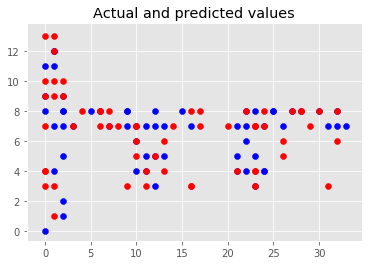

In [268]:
plt.figure(figsize=(20,10))
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.scatter(ygroup3['0_x'], ygroup3['1_x'], c = 'blue', label = 'Actual')
plt.scatter(ygroup3['0_y'], ygroup3['1_y'], c = 'red', label = 'Predicted')


plt.title('Actual and predicted values')


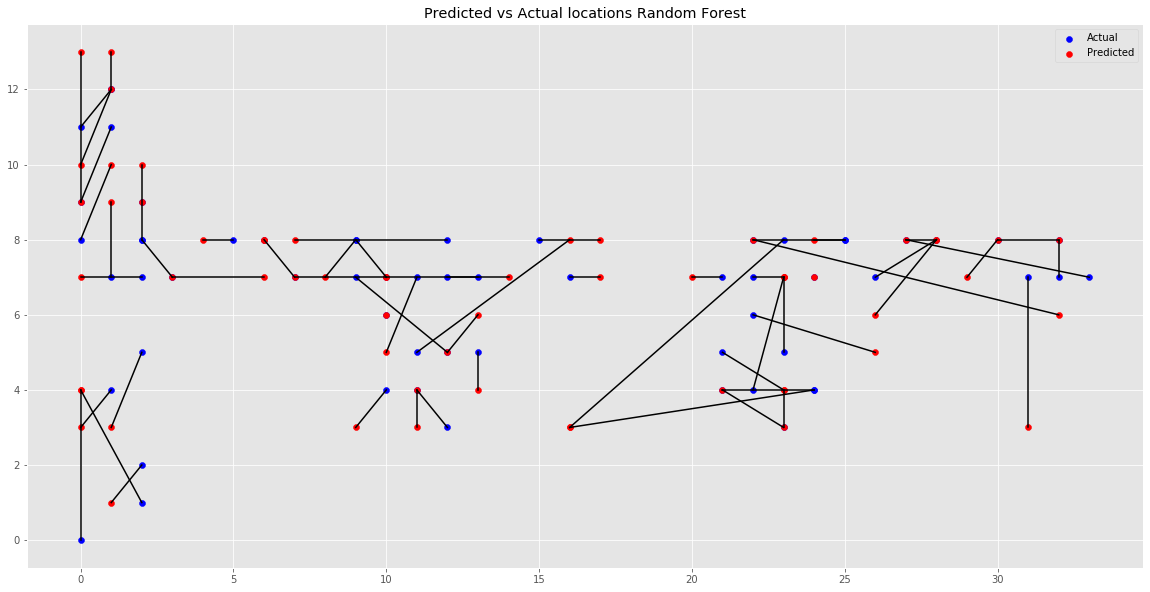

In [280]:
plt.figure(figsize=(20,10))
plt.title('Predicted vs Actual locations Random Forest')
for i, row in ygroup3.iterrows():
    x1, x2 = ygroup3.loc[i,'0_x'], ygroup3.loc[i,'0_y']
    y1, y2 = ygroup3.loc[i,'1_x'], ygroup3.loc[i,'1_y']
    plt.plot([x1,x2], [y1,y2],'k-')
p1 = plt.scatter(ygroup3['0_x'], ygroup3['1_x'], c = 'blue', label = 'Actual')
p2 = plt.scatter(ygroup3['0_y'], ygroup3['1_y'], c = 'red', label = 'Predicted')
plt.legend((p1, p2), ('Actual', 'Predicted'))